In [1]:
library(tidyverse)
library(tidymodels)

# Load data from the specified URL
url <- "https://data-donnees.az.ec.gc.ca/api/file?path=/substances/monitor/canada-s-official-greenhouse-gas-inventory/B-Economic-Sector/EN_GHG_Econ_Can_Prov_Terr.csv"
data <- read.csv(url) |>
  mutate(
    CO2eq = as.numeric(CO2eq),
    Year = as.numeric(Year)
  )

# Filtering for total emissions by province and year, excluding certain regions
total_per_province <- data |>
  filter(Source %in% c("Provincial Inventory Total", "Territorial Inventory Total", "National Inventory Total"),
         !Region %in% c("Canada", "Northwest Territories and Nunavut", "Nunavut")) |>
  na.omit() |>
  select(Year, Region, CO2eq)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

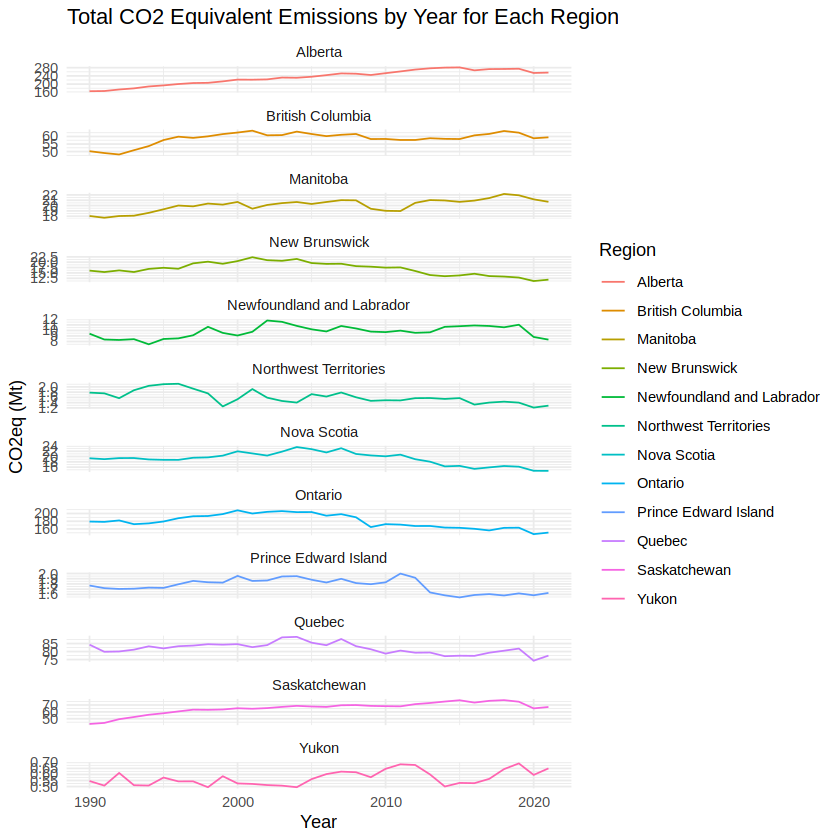

In [2]:
# Plotting total emissions per province over time
total_emissions_plot <- ggplot(total_per_province, aes(x = Year, y = CO2eq, group = Region, color = Region)) +
  geom_line() +
  theme_minimal() +
  labs(title = "Total CO2 Equivalent Emissions by Year for Each Region", x = "Year", y = "CO2eq (Mt)") +
  facet_wrap(~Region, scales = "free_y", ncol = 1)

total_emissions_plot

`summarise()` has grouped output by 'Year', 'Region'. You can override using
the `.groups` argument.


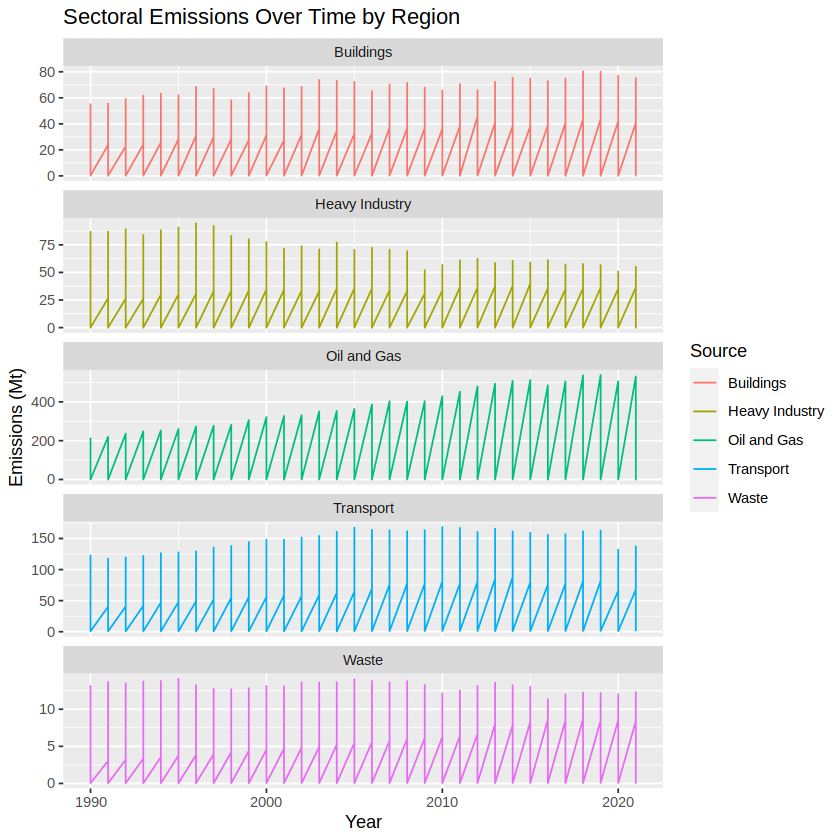

In [3]:
# Filtering data for specific sectors
sector_data <- data |>
  filter(Source %in% c("Oil and Gas", "Transport", "Heavy Industry", "Buildings", "Waste"),
         !Region %in% c("Nunavut", "Northwest Territories and Nunavut", "Canada")) |>
  group_by(Year, Region, Source) |>
  summarize(Sector_CO2eq = sum(CO2eq))

# Plotting sectoral emissions over time
sector_emissions_plot <- ggplot(sector_data, aes(x = Year, y = Sector_CO2eq, color = Source)) +
  geom_line() +
  facet_wrap(~Source, scales = "free_y", ncol = 1) +
  labs(title = "Sectoral Emissions Over Time by Region", x = "Year", y = "Emissions (Mt)")

sector_emissions_plot

In [4]:
# Creating linear models for each sector
linear_models <- sector_data |>
  nest(data = -Source) |>
  mutate(
    model = map(data, ~lm(Sector_CO2eq ~ Year, data = .)),
    summary = map(model, broom::glance)
  )

# Displaying model summaries for each sector
linear_models |> select(Source, summary)

Source,summary
<chr>,<list>
Buildings,"1.462574e-03, -1.151398e-03, 1.952735e+01, 5.595218e-01, 4.549132e-01, 1.000000e+00, -1.685047e+03, 3.376094e+03, 3.387946e+03, 1.456633e+05, 3.820000e+02, 3.840000e+02"
Heavy Industry,"4.423830e-03, 1.817610e-03, 2.190150e+01, 1.697412e+00, 1.934116e-01, 1.000000e+00, -1.729107e+03, 3.464214e+03, 3.476066e+03, 1.832361e+05, 3.820000e+02, 3.840000e+02"
Oil and Gas,"7.864504e-03, 5.267291e-03, 1.076354e+02, 3.028055e+00, 8.264140e-02, 1.000000e+00, -2.340509e+03, 4.687019e+03, 4.698871e+03, 4.425611e+06, 3.820000e+02, 3.840000e+02"
Transport,"6.610222e-03, 4.009725e-03, 4.356990e+01, 2.541907e+00, 1.116878e-01, 1.000000e+00, -1.993227e+03, 3.992453e+03, 4.004305e+03, 7.251644e+05, 3.820000e+02, 3.840000e+02"
Waste,"4.916122e-04, -2.124902e-03, 3.990445e+00, 1.878882e-01, 6.649247e-01, 1.000000e+00, -1.075288e+03, 2.156577e+03, 2.168429e+03, 6.082835e+03, 3.820000e+02, 3.840000e+02"


In [5]:
# Extracting coefficients for comparative analysis
coefficients <- linear_models |>
  mutate(coef = map(model, broom::tidy)) |>
  select(Source, coef)

coefficients

Source,coef
<chr>,<list>
Buildings,"(Intercept) , Year , -148.066411653915 , 0.0807307638505492, 216.450122138121 , 0.107927114565864 , -0.684067119904096, 0.748011879825455 , 0.494347546415178 , 0.454913238968098"
Heavy Industry,"(Intercept) , Year , 331.006741601913 , -0.157708347507609, 242.766234887608 , 0.1210489464576 , 1.3634793230416 , -1.30284774979723 , 0.173534490580792 , 0.193411566545451"
Oil and Gas,"(Intercept) , Year , -2028.97451323858 , 1.0351993346481 , 1193.07953210665 , 0.594897476036966 , -1.70061966418616 , 1.74013065502361 , 0.0898282937514854, 0.0826414007957389"
Transport,"(Intercept) , Year , -733.973431569842, 0.383931379938832, 482.948719412037 , 0.240809574300722, -1.51977508598307, 1.59433602693629 , 0.129394738402242, 0.111687798447941"
Waste,"(Intercept) , Year , -15.7313738189184 , 0.00956000938065834, 44.2319195013283 , 0.0220550739187925 , -0.355656593615523 , 0.433460772603103 , 0.722294069170882 , 0.664924725701708"


In [6]:
# Summarizing the data before pivoting
summarized_data <- data |>
  filter(!Region %in% c("Nunavut", "Northwest Territories and Nunavut", "Canada")) |>
  group_by(Year, Region, Source) |>
  summarize(CO2eq = sum(CO2eq, na.rm = TRUE), .groups = "drop")

# Pivot the data to wide format
correlation_data <- summarized_data |>
  pivot_wider(names_from = Source, values_from = CO2eq) |>
  select(-Year, -Region)  # Remove non-numeric columns

# Convert all columns to numeric
correlation_data <- correlation_data |>
  mutate(across(everything(), as.numeric))

# Compute the correlation matrix
correlation_matrix <- cor(correlation_data, use = "pairwise.complete.obs")

# Viewing the correlation matrix
correlation_matrix


,Agriculture,Buildings,Coal Production,Electricity,Heavy Industry,"Light Manufacturing, Construction and Forest Resources",Oil and Gas,Provincial Inventory Total,Transport,Waste,Territorial Inventory Total
Agriculture,1.0000000,0.6333534,-0.163653899,0.7708662,0.6042035,0.5260495,0.753763032,0.8560228,0.5903894,0.5970038,-0.2002042
Buildings,0.6333534,1.0000000,0.376236471,0.5556668,0.9333942,0.9368528,0.373927064,0.8270628,0.9578238,0.9241489,0.8554965
Coal Production,-0.1636539,0.3762365,1.000000000,-0.1786170,0.3515481,0.6990328,0.008125643,0.1083417,0.6221981,0.5409850,NA
Electricity,0.7708662,0.5556668,-0.178616978,1.0000000,0.5134194,0.4472552,0.803757413,0.8380375,0.4373357,0.4040018,0.3984258
Heavy Industry,0.6042035,0.9333942,0.351548075,0.5134194,1.0000000,0.9595188,0.301087689,0.7830394,0.9403601,0.9585951,0.8563839
"Light Manufacturing, Construction and Forest Resources",0.5260495,0.9368528,0.699032801,0.4472552,0.9595188,1.0000000,0.188325660,0.7070382,0.9524003,0.9429757,-0.1627208
Oil and Gas,0.7537630,0.3739271,0.008125643,0.8037574,0.3010877,0.1883257,1.000000000,0.7825040,0.2737075,0.2640776,0.6226125
Provincial Inventory Total,0.8560228,0.8270628,0.108341683,0.8380375,0.7830394,0.7070382,0.782503993,1.0000000,0.7555496,0.7342479,NA
Transport,0.5903894,0.9578238,0.622198072,0.4373357,0.9403601,0.9524003,0.273707472,0.7555496,1.0000000,0.9765545,0.7802101
Waste,0.5970038,0.9241489,0.540984957,0.4040018,0.9585951,0.9429757,0.264077588,0.7342479,0.9765545,1.0000000,0.7967771
